Starting the Fake News Detection Pipeline...
Loading dataset...
Loaded dataset with 21152 records

--- Dataset Overview ---
       verdict statement_originator  \
0         true         Barack Obama   
1        false           Matt Gaetz   
2  mostly-true         Kelly Ayotte   
3        false             Bloggers   
4    half-true         Bobby Jindal   

                                           statement statement_date  \
0  John McCain opposed bankruptcy protections for...      6/11/2008   
1  "Bennie Thompson actively cheer-led riots in t...       6/7/2022   
2  Says Maggie Hassan was "out of state on 30 day...      5/18/2016   
3  "BUSTED: CDC Inflated COVID Numbers, Accused o...       2/1/2021   
4  "I'm the only (Republican) candidate that has ...      8/30/2015   

  statement_source        factchecker factcheck_date  \
0           speech  Adriel Bettelheim      6/16/2008   
1       television        Yacob Reyes      6/13/2022   
2             news     Clay Wirestone      5/2

100%|██████████| 21152/21152 [02:43<00:00, 129.12it/s]



Preparing target variable...

Class Distribution:
binary_label
0    11760
1     9392
Name: count, dtype: int64
Class imbalance ratio: 1.25
Verdict distribution plot saved as 'verdict_distribution.png'

Performing exploratory data analysis...
Feature correlation plot saved as 'feature_correlation.png'

Top 5 correlated features with label:
ner_PERCENT            0.114328
avg_sentence_length    0.095509
word_count             0.094749
ner_DATE               0.089453
ner_PERSON             0.088498
Name: binary_label, dtype: float64

Preparing features for modeling...

Top TF-IDF features:
['time', 'would', 'said', 'bill', 'country', 'one', 'new', 'american', 'health', 'job', 'trump', 'obama', 'million', 'president', 'people', 'tax', 'percent', 'year', 'state', 'say']

Handling class imbalance with SMOTE...
Original training set shape: [9408 7513]
Resampled training set shape: [9408 9408]

Training traditional ML models...

Training Logistic Regression...
Best parameters: {'C': 1, 'penal

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



Training BERT model...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.658800,0.630720,0.661000,0.549801,0.656101,0.473143
1000,0.636000,0.590945,0.678500,0.614277,0.646465,0.585143



Evaluating BERT model...


BERT Evaluation Results: {'eval_loss': 0.5909450650215149, 'eval_accuracy': 0.6785, 'eval_f1': 0.6142771445710857, 'eval_precision': 0.6464646464646465, 'eval_recall': 0.5851428571428572, 'eval_runtime': 3.9737, 'eval_samples_per_second': 503.314, 'eval_steps_per_second': 31.457, 'epoch': 1.0}

BERT Performance:
Accuracy: 0.6785
Precision: 0.6465
Recall: 0.5851
F1 Score: 0.6143

Training Ensemble model...

Ensemble Performance:
Accuracy: 0.6800
Precision: 0.6274
Recall: 0.6881
F1 Score: 0.6563

Comparing model performance...
Model comparison plot saved as 'model_comparison.png'
Best model: Naive Bayes with F1 Score: 0.6678

Creating prediction function...

Example predictions with different models:

Example 1: President announces new healthcare policy that will benefit all Americans.
  NB Prediction: Real
  Confidence: 0.5291
  Key factors: {'avg_sentence_length': 10.0, 'subjectivity': 0.45454545454545453}
  LR Prediction: Fake
  Confidence: 0.5234
  Key factors: {'readability_score': 

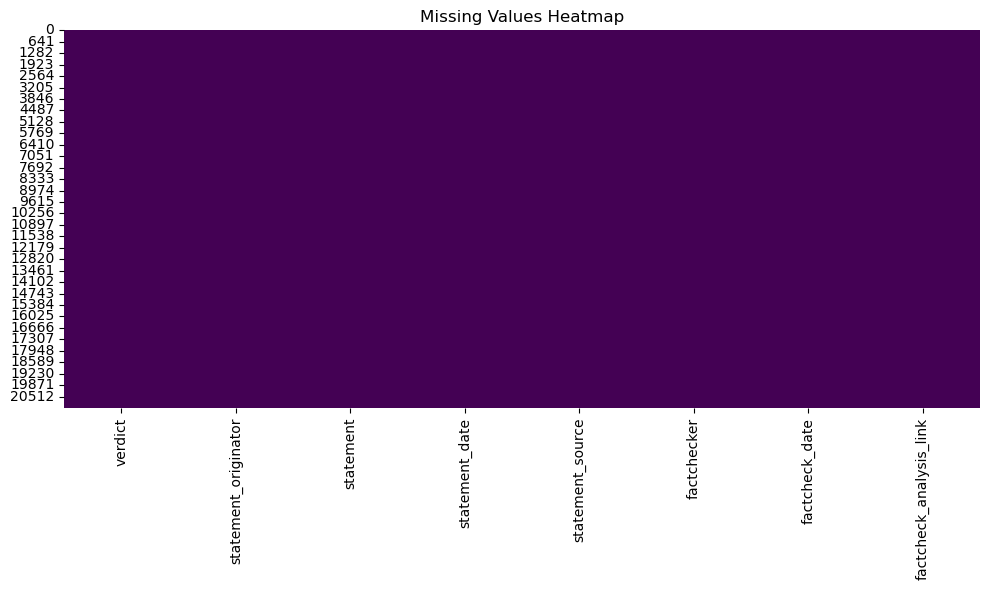

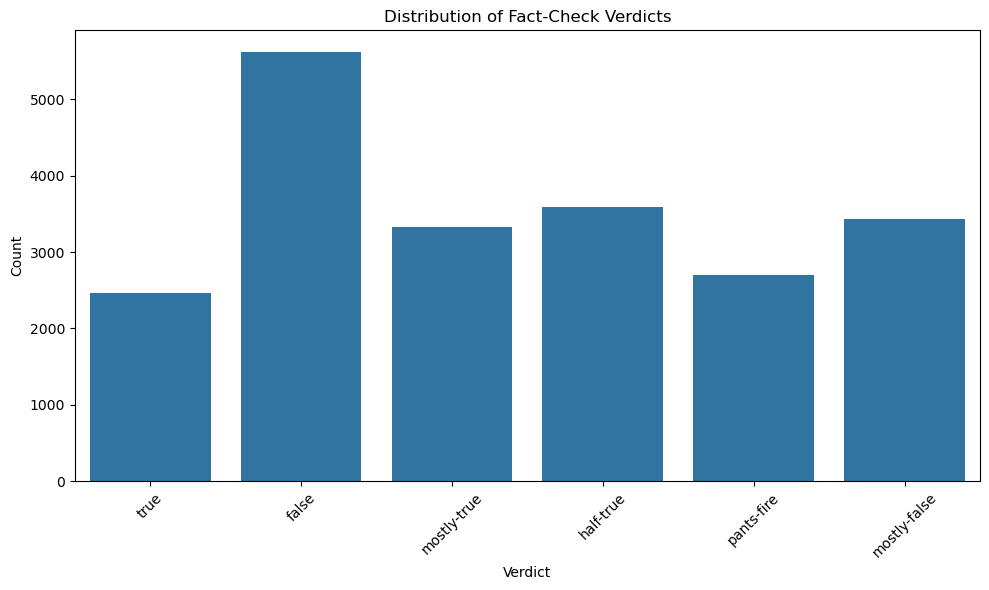

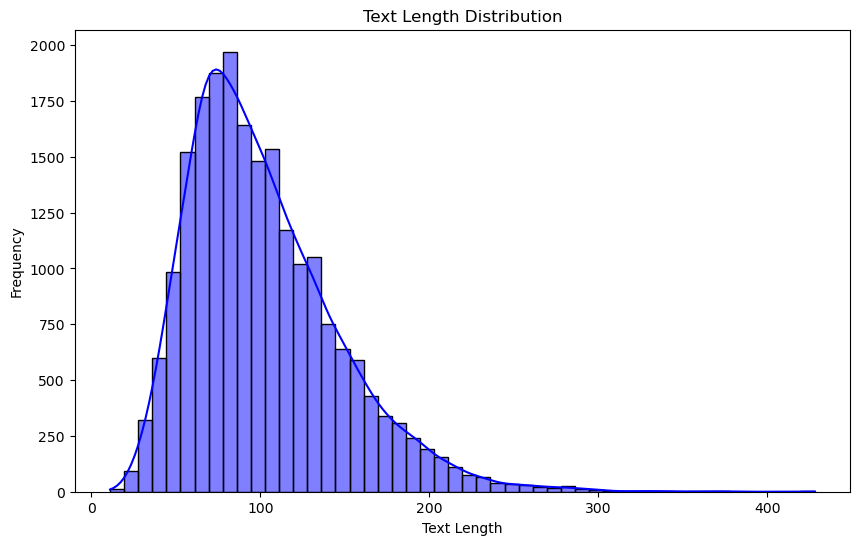

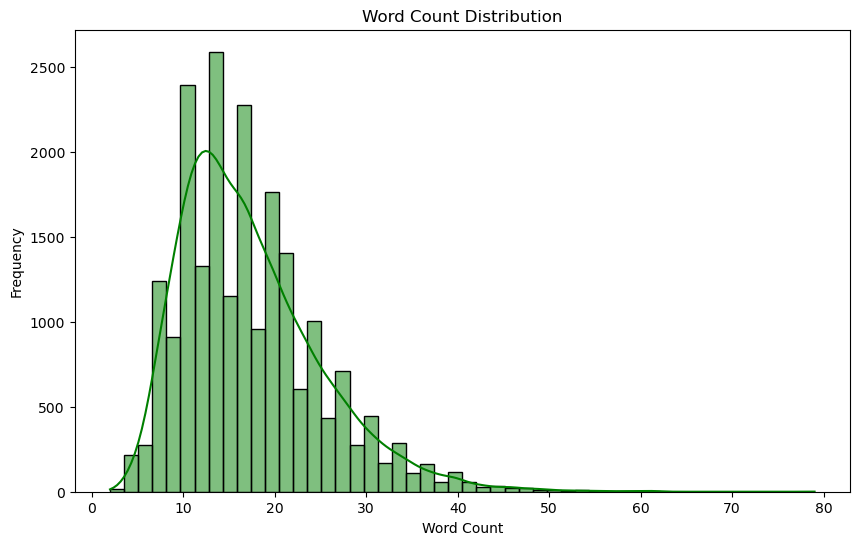

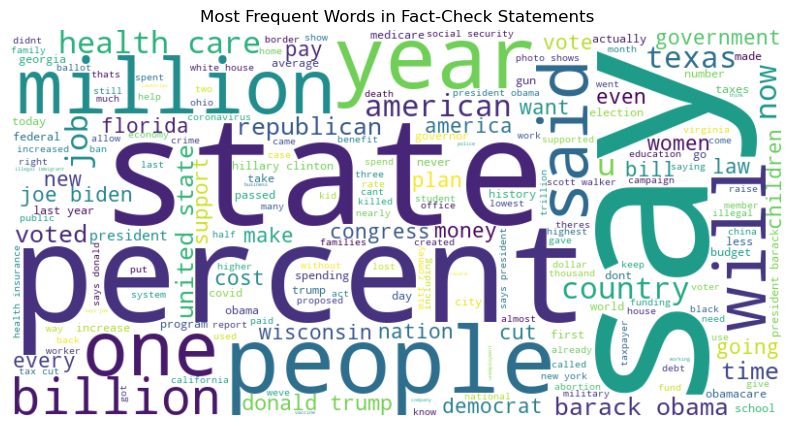

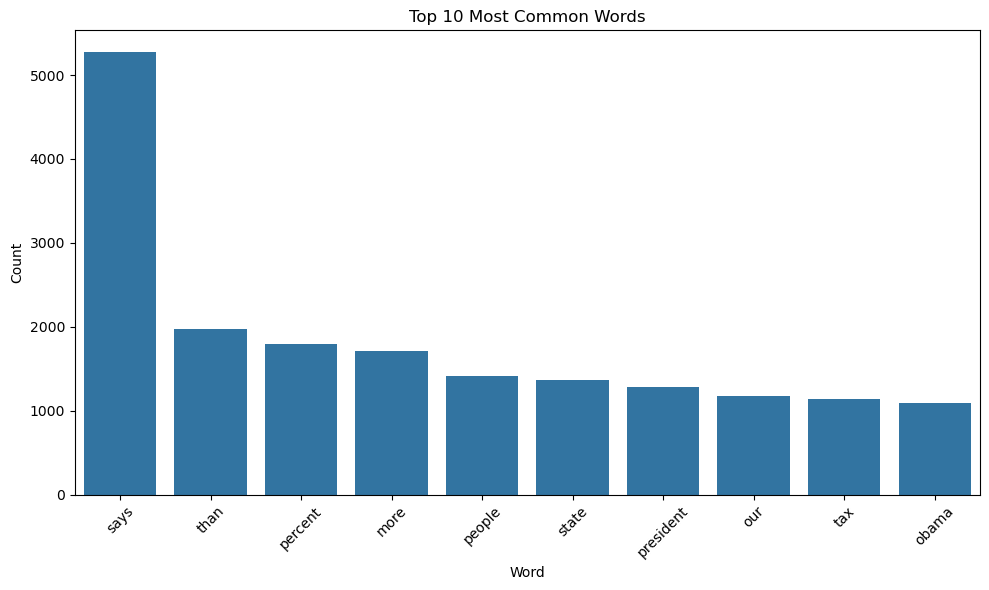

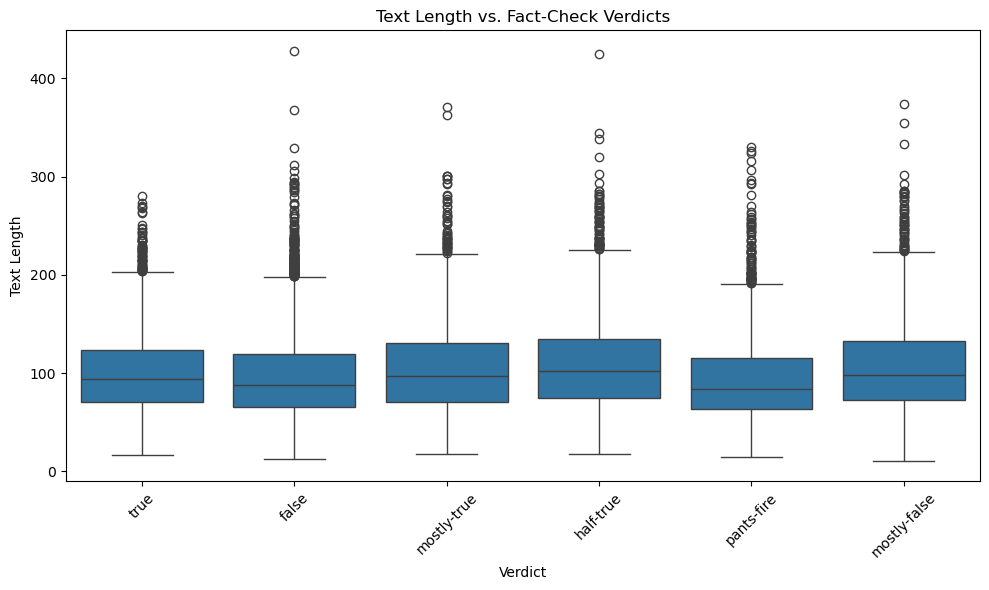

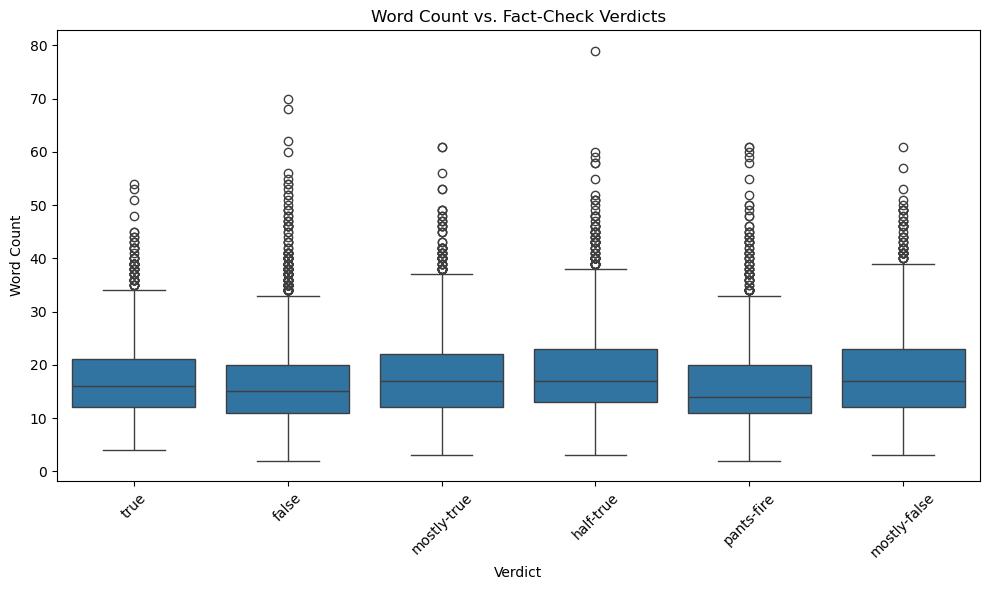

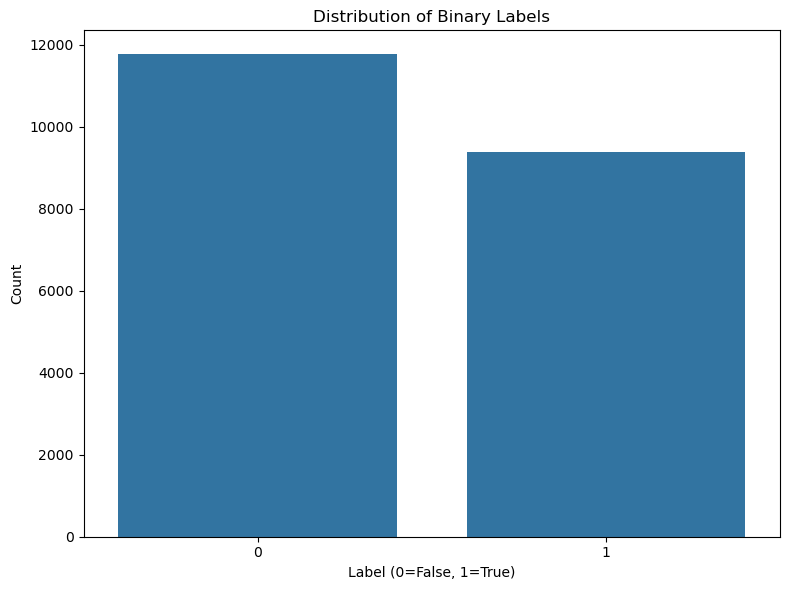

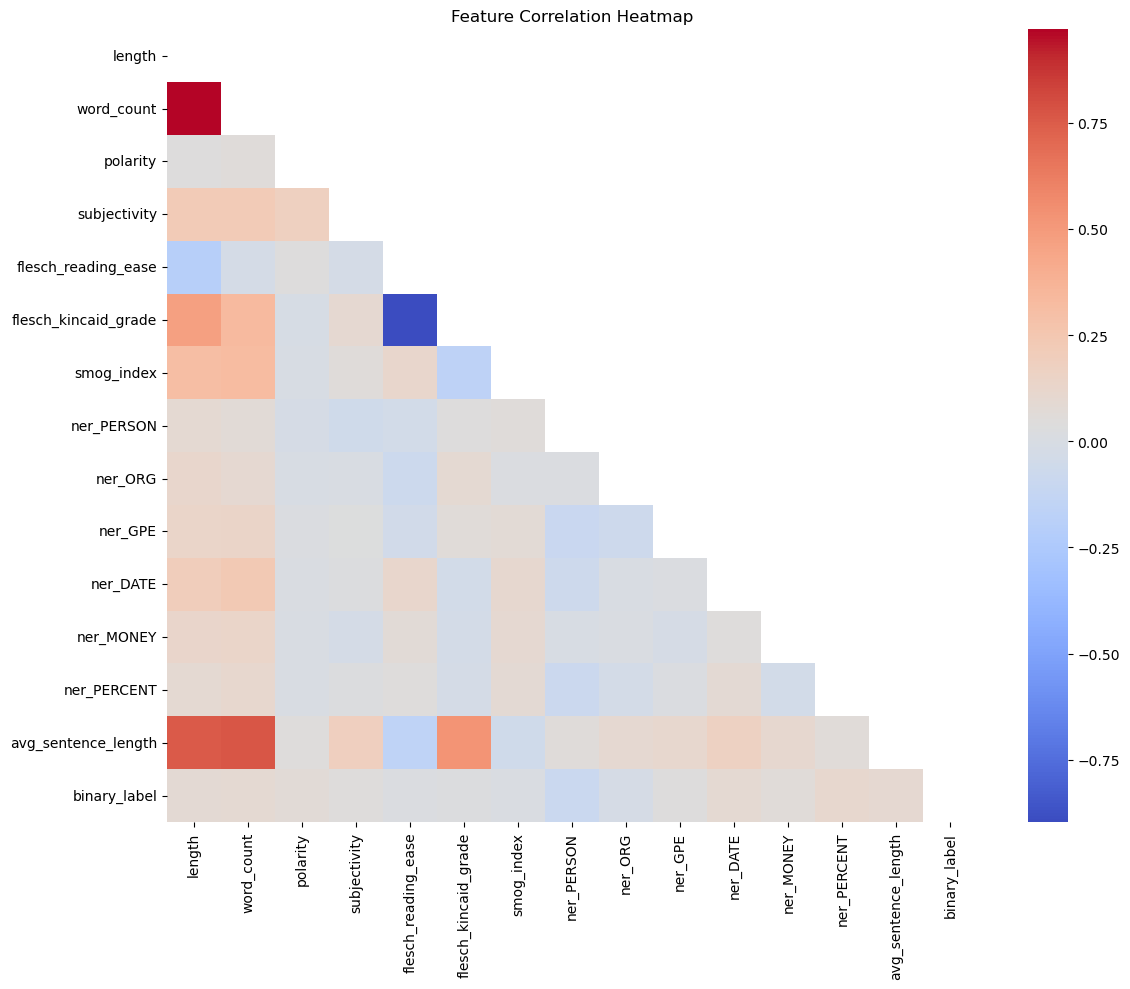

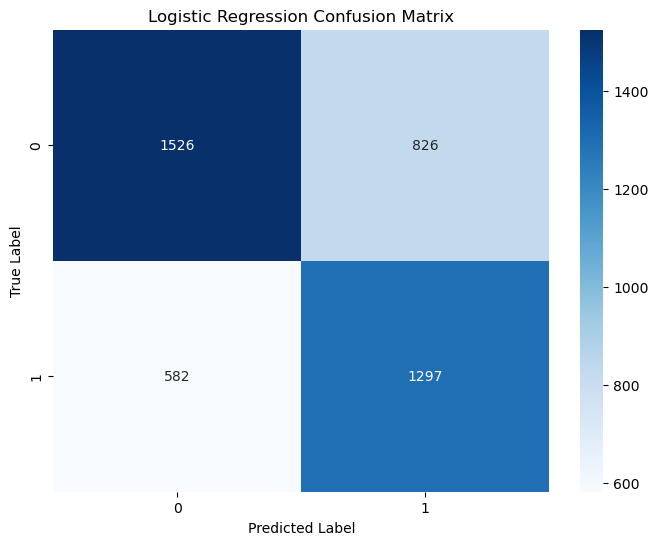

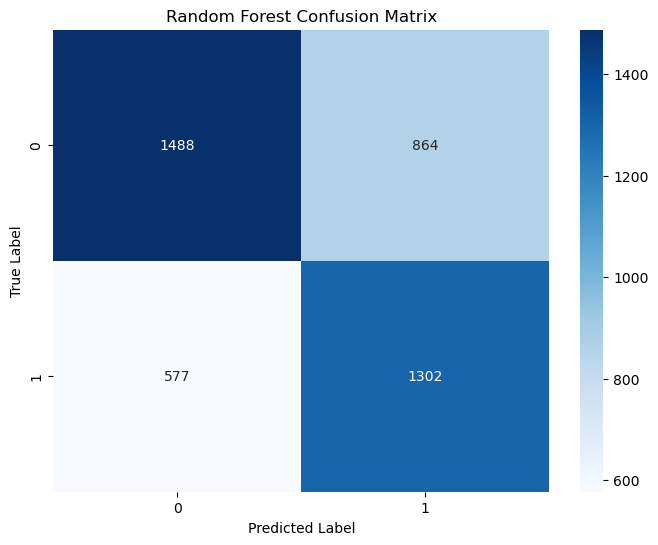

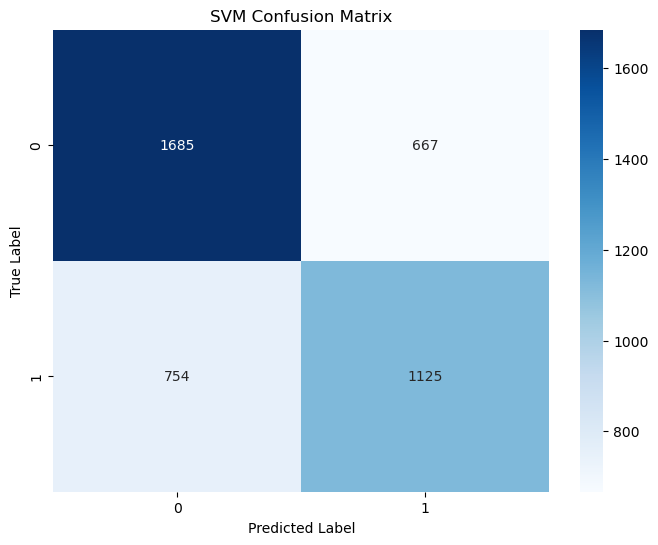

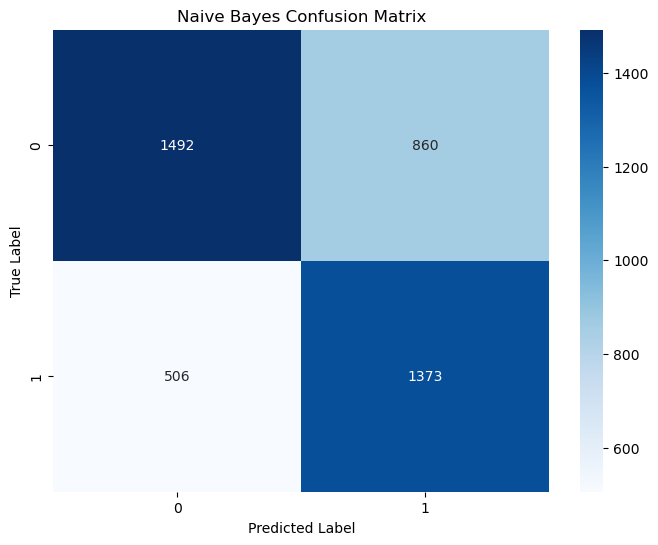

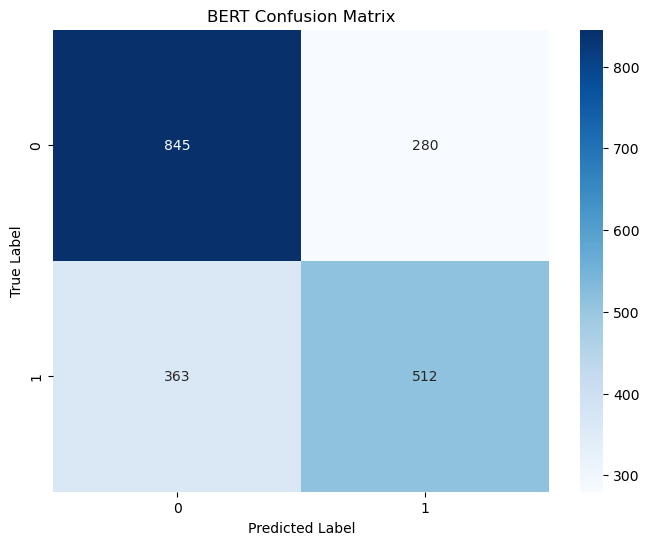

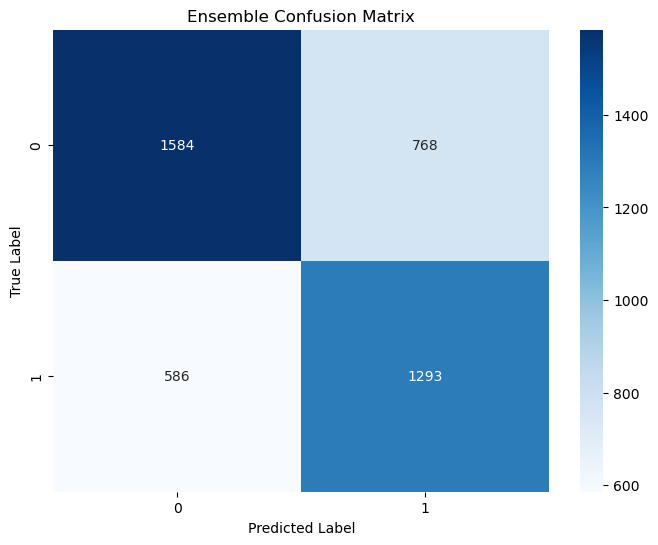

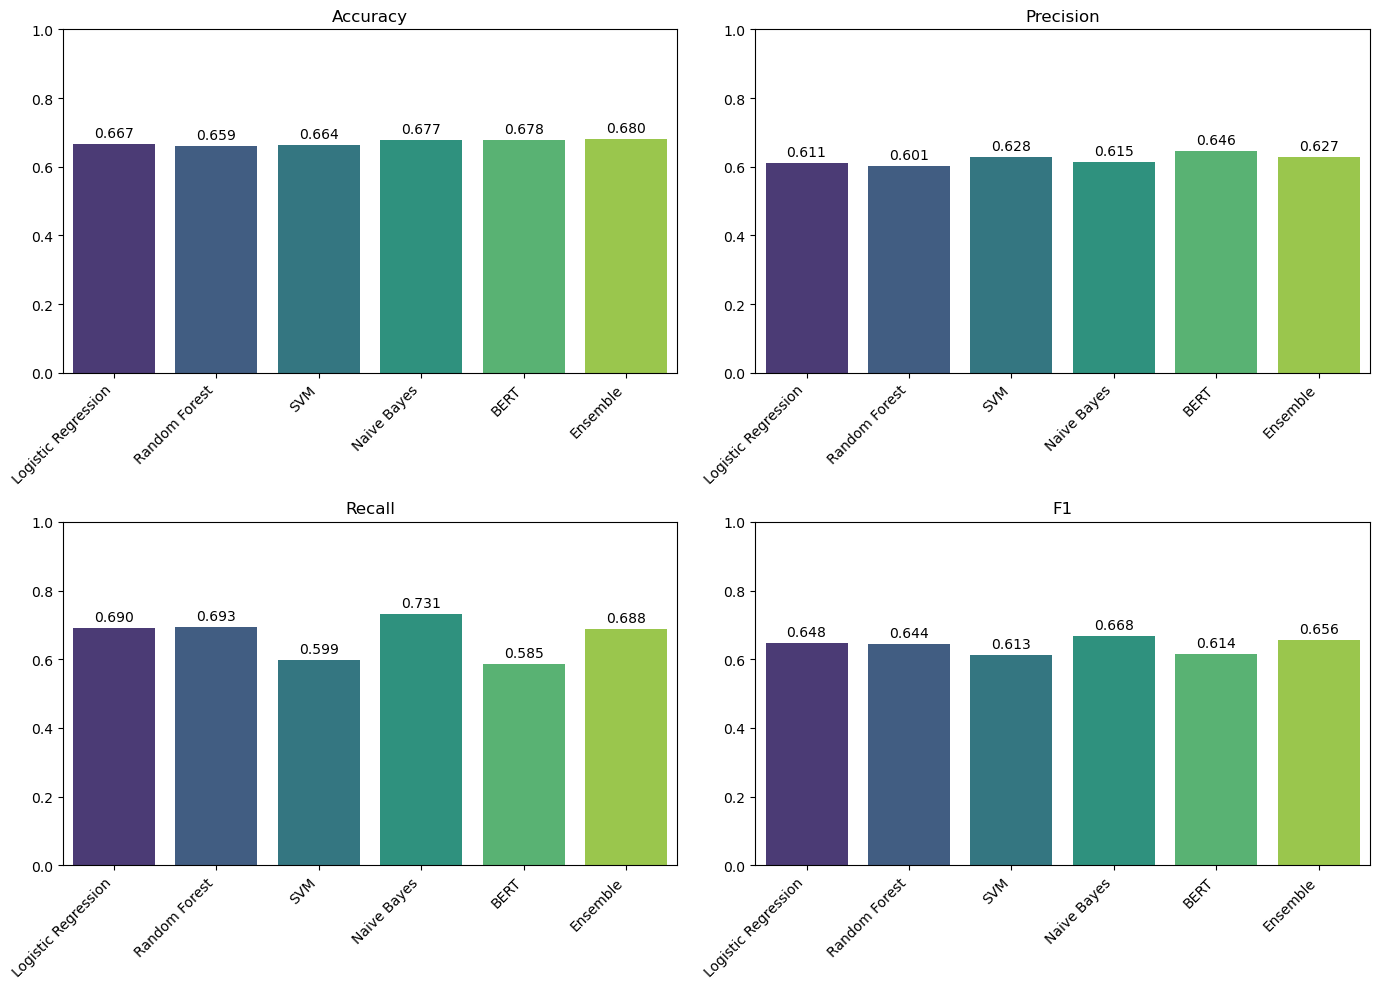

In [1]:
import pandas as pd
import numpy as np
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, TensorDataset
import torch.nn.functional as F
from textblob import TextBlob
import textstat
import spacy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Starting the Fake News Detection Pipeline...")

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Load spaCy model for NER
try:
    nlp = spacy.load('en_core_web_sm')
except:
    print("Installing spaCy model...")
    import os
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# 1. Data Loading and Exploration
print("Loading dataset...")
try:
    df = pd.read_json('politifact_factcheck_data.json', lines=True)
except Exception as e:
    print(f"Error loading dataset: {str(e)}")
    # Fallback location
    paths_to_try = ['./politifact_factcheck_data.json', '../politifact_factcheck_data.json']
    for path in paths_to_try:
        try:
            df = pd.read_json(path, lines=True)
            print(f"Loaded from {path}")
            break
        except:
            continue
    else:
        raise FileNotFoundError("Could not find the dataset file")

print(f"Loaded dataset with {len(df)} records")

# Initial EDA
print("\n--- Dataset Overview ---")
print(df.head())

# Dataset Info
print("\n--- Dataset Summary ---")
df.info()

# Summary of numerical columns
print("\n--- Summary Statistics ---")
print(df.describe())

# Check for missing values
print("\n--- Missing Values ---")
missing_values = df.isnull().sum()
print(missing_values)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.tight_layout()
plt.savefig('missing_values_heatmap.png')
print("Missing values heatmap saved as 'missing_values_heatmap.png'")

# Distribution of labels (target variable)
plt.figure(figsize=(10, 6))
sns.countplot(x='verdict', data=df)
plt.title("Distribution of Fact-Check Verdicts")
plt.xlabel("Verdict")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('verdict_distribution_raw.png')
print("Verdict distribution plot saved as 'verdict_distribution_raw.png'")

# 2. Text Preprocessing
print("\nPerforming text preprocessing...")

# Basic clean text function
def basic_clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    return text.strip()

# Add temporary columns for basic EDA
df['basic_text'] = df['statement'].apply(basic_clean_text)

# Text length distribution
df['text_length'] = df['basic_text'].apply(len)
print("\n--- Text Length Summary ---")
print(df['text_length'].describe())

# Visualize Text Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color="blue")
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.savefig('text_length_distribution.png')
print("Text length distribution plot saved as 'text_length_distribution.png'")

# Word count distribution
df['word_count'] = df['basic_text'].apply(lambda x: len(x.split()))
print("\n--- Word Count Summary ---")
print(df['word_count'].describe())

# Visualize Word Count Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color="green")
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.savefig('word_count_distribution.png')
print("Word count distribution plot saved as 'word_count_distribution.png'")

# Create a Word Cloud
try:
    word_string = ' '.join(df['basic_text'].dropna().tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(word_string)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Most Frequent Words in Fact-Check Statements")
    plt.axis('off')
    plt.savefig('wordcloud.png')
    print("Word cloud saved as 'wordcloud.png'")

    # Top 10 most common words (excluding common stopwords)
    stop_words = set(['the', 'and', 'for', 'that', 'is', 'in', 'it', 'to', 'of', 'on', 
                       'with', 'as', 'was', 'at', 'by', 'an', 'be', 'this', 'from', 'are', 
                       'or', 'but', 'not', 'you', 'has', 'have', 'we', 'they', 'their', 'a', 'can'])

    all_words = ' '.join(df['basic_text'].dropna().tolist()).split()
    filtered_words = [word for word in all_words if word not in stop_words]

    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(10)

    print("\n--- Top 10 Most Common Words (Excluding Stopwords) ---")
    for word, count in top_words:
        print(f"{word}: {count}")
        
    # Create bar chart of top words
    plt.figure(figsize=(10, 6))
    words = [word for word, count in top_words]
    counts = [count for word, count in top_words]
    sns.barplot(x=words, y=counts)
    plt.title("Top 10 Most Common Words")
    plt.xlabel("Word")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('top_words.png')
    print("Top words chart saved as 'top_words.png'")
except Exception as e:
    print(f"Error creating word cloud: {str(e)}")

# Text Length vs. Label (Analysis of Text Length by Verdict)
plt.figure(figsize=(10, 6))
sns.boxplot(x='verdict', y='text_length', data=df)
plt.title("Text Length vs. Fact-Check Verdicts")
plt.xlabel("Verdict")
plt.ylabel("Text Length")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('text_length_by_verdict.png')
print("Text length by verdict plot saved as 'text_length_by_verdict.png'")

# Word Count vs. Label
plt.figure(figsize=(10, 6))
sns.boxplot(x='verdict', y='word_count', data=df)
plt.title("Word Count vs. Fact-Check Verdicts")
plt.xlabel("Verdict")
plt.ylabel("Word Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('word_count_by_verdict.png')
print("Word count by verdict plot saved as 'word_count_by_verdict.png'")

# Advanced text preprocessing and feature extraction
def extract_features(text):
    """Extract linguistic and readability features from text"""
    features = {}
    
    # Basic text features
    features['length'] = len(text)
    features['word_count'] = len(text.split())
    
    # Sentiment analysis
    blob = TextBlob(text)
    features['polarity'] = blob.sentiment.polarity
    features['subjectivity'] = blob.sentiment.subjectivity
    
    # Readability scores
    features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
    features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
    features['smog_index'] = textstat.smog_index(text)
    
    # NER features
    doc = nlp(text[:10000])  # Limit text size for processing speed
    entity_types = [ent.label_ for ent in doc.ents]
    counter = Counter(entity_types)
    for ent_type in ['PERSON', 'ORG', 'GPE', 'DATE', 'MONEY', 'PERCENT']:
        features[f'ner_{ent_type}'] = counter.get(ent_type, 0)
    
    # Complexity measures
    sentences = [sent.text for sent in doc.sents]
    if sentences:
        features['avg_sentence_length'] = sum(len(s.split()) for s in sentences) / len(sentences)
    else:
        features['avg_sentence_length'] = 0
    
    return features

def preprocess_text(text):
    """Advanced text preprocessing"""
    if not isinstance(text, str):
        return "", ""
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Keep a copy of text for feature extraction
    text_for_features = text
    
    # Remove numbers and special characters for tokenization
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    # Join tokens back into text
    clean_text = ' '.join(tokens)
    
    return clean_text, text_for_features

# Apply preprocessing to the dataset
print("Cleaning text and extracting features...")
df['cleaned_text'] = ""
df['text_for_features'] = ""
feature_cols = []

# Process texts and extract features
for idx, row in tqdm(df.iterrows(), total=len(df)):
    if isinstance(row['statement'], str):
        clean_text, text_for_features = preprocess_text(row['statement'])
        df.at[idx, 'cleaned_text'] = clean_text
        df.at[idx, 'text_for_features'] = text_for_features
        
        # Extract features once for demonstration
        if idx == 0:
            features = extract_features(text_for_features)
            feature_cols = list(features.keys())
            for col in feature_cols:
                df[col] = 0
        
        # Extract features for each text
        if len(text_for_features) > 0:
            features = extract_features(text_for_features)
            for key, value in features.items():
                df.at[idx, key] = value

# 3. Target Variable Preparation
print("\nPreparing target variable...")
# Map verdicts to binary labels (true=1, false=0)
binary_map = {
    'true': 1,
    'mostly-true': 1,
    'half-true': 0.5,  # Could be mapped differently based on needs
    'mostly-false': 0,
    'false': 0,
    'pants-fire': 0
}

df['label'] = df['verdict'].map(binary_map)
# For binary classification, map half-true to 0
df['binary_label'] = df['label'].apply(lambda x: 1 if x >= 0.5 else 0)

# Check for class imbalance
print("\nClass Distribution:")
class_counts = df['binary_label'].value_counts()
print(class_counts)
print(f"Class imbalance ratio: {class_counts[0]/class_counts[1]:.2f}")

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='binary_label', data=df)
plt.title("Distribution of Binary Labels")
plt.xlabel("Label (0=False, 1=True)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('verdict_distribution.png')
print("Verdict distribution plot saved as 'verdict_distribution.png'")

# 4. Exploratory Data Analysis
print("\nPerforming exploratory data analysis...")

# Analyze correlation between features and labels
corr_matrix = df[feature_cols + ['binary_label']].corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig('feature_correlation.png')
print("Feature correlation plot saved as 'feature_correlation.png'")

# Top 5 most correlated features with label
top_corrs = corr_matrix['binary_label'].drop('binary_label').abs().sort_values(ascending=False).head(5)
print("\nTop 5 correlated features with label:")
print(top_corrs)

# 5. Feature Engineering and Selection
print("\nPreparing features for modeling...")

# Combine linguistic features with TF-IDF
X_linguistic = df[feature_cols]

# Prepare TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.85
)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Get the most important TF-IDF features
feature_names = tfidf_vectorizer.get_feature_names_out()
top_tfidf_indices = X_tfidf.sum(axis=0).A1.argsort()[-20:]
top_tfidf_features = [feature_names[i] for i in top_tfidf_indices]
print("\nTop TF-IDF features:")
print(top_tfidf_features)

# Train-Test Split
X_tfidf_train, X_tfidf_test, X_ling_train, X_ling_test, y_train, y_test = train_test_split(
    X_tfidf, X_linguistic, df['binary_label'], 
    test_size=0.2, random_state=42, stratify=df['binary_label']
)

# 6. Handle Class Imbalance using SMOTE (only on training data)
print("\nHandling class imbalance with SMOTE...")
smote = SMOTE(random_state=42)
X_tfidf_train_resampled, y_train_resampled = smote.fit_resample(X_tfidf_train, y_train)

print(f"Original training set shape: {np.bincount(y_train)}")
print(f"Resampled training set shape: {np.bincount(y_train_resampled)}")

# 7. Model Evaluation Function
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and print metrics"""
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# 8. Traditional ML Models
print("\nTraining traditional ML models...")

# Logistic Regression
print("\nTraining Logistic Regression...")
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],  # Only l2 works with 'lbfgs' solver
    'solver': ['liblinear']  # Changed from 'lbfgs' to 'liblinear' for l1 penalty
}

lr_cv = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, 
                    scoring='f1', n_jobs=1)  # Changed n_jobs from -1 to 1
lr_cv.fit(X_tfidf_train_resampled, y_train_resampled)
print(f"Best parameters: {lr_cv.best_params_}")
lr_metrics = evaluate_model(lr_cv.best_estimator_, X_tfidf_test, y_test, "Logistic Regression")

# Random Forest
print("\nTraining Random Forest...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf_cv = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, 
                    scoring='f1', n_jobs=1)  # Changed n_jobs from -1 to 1
rf_cv.fit(X_tfidf_train_resampled, y_train_resampled)
print(f"Best parameters: {rf_cv.best_params_}")
rf_metrics = evaluate_model(rf_cv.best_estimator_, X_tfidf_test, y_test, "Random Forest")

# SVM Model
print("\nTraining SVM model...")
svm_params = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svm_cv = GridSearchCV(SVC(probability=True), svm_params, cv=3, 
                     scoring='f1', n_jobs=1)  # Changed n_jobs from -1 to 1
svm_cv.fit(X_tfidf_train_resampled, y_train_resampled)
print(f"Best parameters: {svm_cv.best_params_}")
svm_metrics = evaluate_model(svm_cv.best_estimator_, X_tfidf_test, y_test, "SVM")

# Naive Bayes
print("\nTraining Naive Bayes model...")
nb_model = MultinomialNB()
nb_model.fit(X_tfidf_train_resampled, y_train_resampled)
nb_metrics = evaluate_model(nb_model, X_tfidf_test, y_test, "Naive Bayes")

# 9. BERT Model
print("\nSetting up BERT model...")

# Define a custom dataset class for BERT
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):  # Reduced max_length
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Remove the batch dimension
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding['labels'] = torch.tensor(label, dtype=torch.long)
        
        return encoding

# Compute metrics function for BERT evaluation
def compute_metrics(pred):
    """Function to compute evaluation metrics for BERT"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

try:
    # Prepare data for BERT
    texts_train, texts_test, labels_train, labels_test = train_test_split(
        df['cleaned_text'].tolist(), df['binary_label'].tolist(), 
        test_size=0.2, random_state=42, stratify=df['binary_label']
    )
    
    # Balance training set if needed
    if class_counts[0] / class_counts[1] > 1.5:
        # Find minority class examples
        minority_indices = [i for i, label in enumerate(labels_train) if label == 1]
        majority_indices = [i for i, label in enumerate(labels_train) if label == 0]
        
        # Simple oversampling of minority class
        sampled_majority_indices = np.random.choice(majority_indices, len(minority_indices), replace=False)
        balanced_indices = list(sampled_majority_indices) + minority_indices * 2
        
        texts_train_balanced = [texts_train[i] for i in balanced_indices]
        labels_train_balanced = [labels_train[i] for i in balanced_indices]
    else:
        texts_train_balanced = texts_train
        labels_train_balanced = labels_train
    
    # Determine if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize BERT tokenizer with a smaller vocab
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Create smaller datasets
    train_dataset = FakeNewsDataset(texts_train_balanced[:10000], labels_train_balanced[:10000], tokenizer)
    test_dataset = FakeNewsDataset(texts_test[:2000], labels_test[:2000], tokenizer)
    
    # Initialize BERT model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2
    ).to(device)
    
    # Define training arguments with smaller batch sizes and lower training steps
    training_args = TrainingArguments(
        output_dir='./results/bert',
        num_train_epochs=1,  # Reduced epochs
        per_device_train_batch_size=8,  # Reduced batch size
        per_device_eval_batch_size=16,  # Reduced batch size
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=100,
        evaluation_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        load_best_model_at_end=True,
        # Critical fix: use a metric that the compute_metrics function returns
        metric_for_best_model="eval_f1"
    )
    
    # Define Trainer with compute_metrics function
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics  # This is the key addition
    )
    
    # Train the model
    print("\nTraining BERT model...")
    trainer.train()
    
    # Evaluate BERT model
    print("\nEvaluating BERT model...")
    bert_eval_results = trainer.evaluate()
    print(f"BERT Evaluation Results: {bert_eval_results}")
    
    # Get predictions using trained model
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    
    # Calculate metrics
    bert_metrics = {
        'accuracy': accuracy_score(labels_test[:2000], preds),
        'precision': precision_score(labels_test[:2000], preds),
        'recall': recall_score(labels_test[:2000], preds),
        'f1': f1_score(labels_test[:2000], preds)
    }
    
    print("\nBERT Performance:")
    print(f"Accuracy: {bert_metrics['accuracy']:.4f}")
    print(f"Precision: {bert_metrics['precision']:.4f}")
    print(f"Recall: {bert_metrics['recall']:.4f}")
    print(f"F1 Score: {bert_metrics['f1']:.4f}")
    
    # Save confusion matrix
    cm = confusion_matrix(labels_test[:2000], preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('BERT Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('bert_confusion_matrix.png')
    
except Exception as e:
    print(f"Error training BERT model: {str(e)}")
    bert_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}

# 10. Ensemble model
try:
    print("\nTraining Ensemble model...")
    ensemble = VotingClassifier(
        estimators=[
            ('lr', lr_cv.best_estimator_),
            ('rf', rf_cv.best_estimator_),
            ('svm', svm_cv.best_estimator_),
            ('nb', nb_model)
        ],
        voting='soft'
    )
    
    ensemble.fit(X_tfidf_train_resampled, y_train_resampled)
    ensemble_metrics = evaluate_model(ensemble, X_tfidf_test, y_test, "Ensemble")
    
except Exception as e:
    print(f"Error training Ensemble model: {str(e)}")
    ensemble_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}

# 11. Model Comparison
print("\nComparing model performance...")

models = {
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'SVM': svm_metrics,
    'Naive Bayes': nb_metrics,
    'BERT': bert_metrics,
    'Ensemble': ensemble_metrics
}

# Create comparison plot
metrics = ['accuracy', 'precision', 'recall', 'f1']
model_names = list(models.keys())

# Filter models with valid metrics
valid_models = {k: v for k, v in models.items() if v['accuracy'] > 0}
valid_model_names = list(valid_models.keys())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    values = [valid_models[model][metric] for model in valid_model_names]
    ax = axes[i]
    sns.barplot(x=valid_model_names, y=values, ax=ax, palette='viridis')
    ax.set_title(f'{metric.capitalize()}')
    ax.set_ylim(0, 1)
    ax.set_xticklabels(valid_model_names, rotation=45, ha='right')
    
    for j, v in enumerate(values):
        ax.text(j, v + 0.02, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.savefig('model_comparison.png')
print("Model comparison plot saved as 'model_comparison.png'")

# Find best model
best_model = None
best_f1 = 0
best_model_name = "Unknown"

for model_name, metrics in models.items():
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_model_name = model_name

print(f"Best model: {best_model_name} with F1 Score: {best_f1:.4f}")

# 12. Example Prediction Function
print("\nCreating prediction function...")

def predict_fake_news(text, model_type='best'):
    """
    Predict if a news article is real or fake
    
    Parameters:
    -----------
    text : str
        The news article text
    model_type : str
        Model to use or 'best' for best performing model
        
    Returns:
    --------
    prediction : int
        1 for real news, 0 for fake news
    probability : float
        Probability of the prediction
    explanation : dict
        Feature importance or explanation
    """
    # If best model is requested, set model_type to the best model
    if model_type == 'best':
        model_type = best_model_name.lower().replace(' ', '_')
    
    # Preprocess the text
    clean_text, text_for_features = preprocess_text(text)
    
    # Extract features for explanation
    features = extract_features(text_for_features)
    explanation = {}
    
    # For traditional models
    if model_type in ['lr', 'logistic_regression']:
        # Transform text
        tfidf_vector = tfidf_vectorizer.transform([clean_text])
        
        # Predict
        prediction = lr_cv.predict(tfidf_vector)[0]
        probability = lr_cv.predict_proba(tfidf_vector)[0][prediction]
        
        # Add key features for explanation
        explanation['sentiment_polarity'] = features['polarity']
        explanation['readability_score'] = features['flesch_reading_ease']
        
    elif model_type in ['rf', 'random_forest']:
        # Transform text
        tfidf_vector = tfidf_vectorizer.transform([clean_text])
        
        # Predict
        prediction = rf_cv.predict(tfidf_vector)[0]
        probability = rf_cv.predict_proba(tfidf_vector)[0][prediction]
        
        # Add feature importance if available
        if hasattr(rf_cv.best_estimator_, 'feature_importances_'):
            # Get most important features
            feature_names = tfidf_vectorizer.get_feature_names_out()
            importances = rf_cv.best_estimator_.feature_importances_
            indices = np.argsort(importances)[-5:]
            for i in indices:
                if i < len(feature_names):
                    explanation[feature_names[i]] = importances[i]
    
    elif model_type in ['svm']:
        # Transform text
        tfidf_vector = tfidf_vectorizer.transform([clean_text])
        
        # Predict
        prediction = svm_cv.predict(tfidf_vector)[0]
        probability = svm_cv.predict_proba(tfidf_vector)[0][prediction]
        
        # Add NER features to explanation
        for key, value in features.items():
            if key.startswith('ner_'):
                explanation[key] = value
    
    elif model_type in ['nb', 'naive_bayes']:
        # Transform text
        tfidf_vector = tfidf_vectorizer.transform([clean_text])
        
        # Predict
        prediction = nb_model.predict(tfidf_vector)[0]
        probability = nb_model.predict_proba(tfidf_vector)[0][prediction]
        
        # Add linguistic features to explanation
        explanation['subjectivity'] = features['subjectivity']
        explanation['avg_sentence_length'] = features['avg_sentence_length']
    
    elif model_type in ['ensemble']:
        # Transform text
        tfidf_vector = tfidf_vectorizer.transform([clean_text])
        
        # Predict
        prediction = ensemble.predict(tfidf_vector)[0]
        probability = ensemble.predict_proba(tfidf_vector)[0][prediction]
        
        # Combine explanations from multiple models
        explanation['sentiment_polarity'] = features['polarity']
        explanation['subjectivity'] = features['subjectivity']
        explanation['readability_score'] = features['flesch_reading_ease']
    
    elif model_type in ['bert']:
        # Tokenize for BERT
        encoding = tokenizer(
            clean_text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        
        # Move to device
        encoding = {key: val.to(device) for key, val in encoding.items()}
        
        # Get prediction
        with torch.no_grad():
            outputs = model(**encoding)
            logits = outputs.logits
            probabilities = F.softmax(logits, dim=1)
            
        prediction = torch.argmax(probabilities, dim=1).item()
        probability = probabilities[0][prediction].item()
        
        # BERT doesn't provide direct feature importance
        explanation['used_bert'] = True
        explanation['sentiment_polarity'] = features['polarity']
        explanation['named_entities'] = sum(features.get(f'ner_{ent}', 0) for ent in ['PERSON', 'ORG', 'GPE'])
    
    else:
        raise ValueError("Invalid model type. Choose from 'lr', 'rf', 'svm', 'nb', 'ensemble', 'bert' or 'best'")
    
    return prediction, probability, explanation

# Example usage
print("\nExample predictions with different models:")

example_texts = [
    "President announces new healthcare policy that will benefit all Americans.",
    "BREAKING: Secret government documents reveal conspiracy to control the weather.",
    "Studies show that regular exercise reduces risk of heart disease.",
    "Scientists confirm that vaccines contain tracking microchips funded by Bill Gates."
]

for i, text in enumerate(example_texts):
    print(f"\nExample {i+1}: {text}")
    
    # Try prediction with different models
    for model_type in ['nb', 'lr', 'ensemble']:
        try:
            prediction, probability, explanation = predict_fake_news(text, model_type=model_type)
            print(f"  {model_type.upper()} Prediction: {'Real' if prediction == 1 else 'Fake'}")
            print(f"  Confidence: {probability:.4f}")
            
            # Show top explanations
            if explanation and len(explanation) > 0:
                top_explanation = dict(sorted(explanation.items(), key=lambda x: abs(x[1]) if isinstance(x[1], (int, float)) else 0, reverse=True)[:2])
                print(f"  Key factors: {top_explanation}")
        except Exception as e:
            print(f"  Error with {model_type}: {str(e)}")

print("\nFake News Detection Pipeline Complete!")